In [1]:
import pickle
import os

data_dir = r"D:\Videos Zebrafish\ConfocalLike3 (Febrero 2024)"#r"N:\Data Labo"#
data_name = 'organized_data_behavior_2024_with_freezing.pkl' #"processed_data_oled_aud_9_ROIS.pkl" #

os.chdir(data_dir)

# Reading the list from the file using Pickle
with open(data_name, 'rb') as file:
    data = pickle.load(file)

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tools.tools import add_constant

# Initialize lists to hold data for DataFrame
visual_intensity = []
auditory_intensity = []
age_of_fish = []
sequence_in_fish = []
sequence_in_day = []
event_frequency_pre_stim = []
proportion_freezing_pre_stim = []
is_escape_trial = []
fish_id = []

# Calculate necessary values
for stim_code in data['colors'].keys():
    for i in range(len(data[stim_code]['fish'])):
        # Append directly accessible values
        visual_intensity.append(data[stim_code]['vis_intensity'][i])
        auditory_intensity.append(data[stim_code]['aud_intensity'][i])
        age_of_fish.append(data[stim_code]['age'][i])
        sequence_in_fish.append(data[stim_code]['sequence_in_fish'][i])
        sequence_in_day.append(data[stim_code]['sequence_in_day'][i])
        is_escape_trial.append(data[stim_code]['is_escape'][i])
        
        fish_id.append(data[stim_code]['fish'][i])

        # Calculate event frequency before stim window
        stim_start = data['stim_window'][0]
        event_times = data[stim_code]['event_times'][i]
        event_frequency_pre_stim.append(len([time for time in event_times if time < stim_start]) / stim_start)

        # Calculate proportion of time spent freezing before stim window
        freezing_events = data[stim_code]['freezing_events'][i]
        total_freezing_time = sum([end - start for start, end in freezing_events if end < stim_start])
        proportion_freezing_pre_stim.append(total_freezing_time / stim_start)

# Create DataFrame
df = pd.DataFrame({
    'visual_intensity': visual_intensity,
    'auditory_intensity': auditory_intensity,
    'age_of_fish': age_of_fish,
    'sequence_in_fish': sequence_in_fish,
    'sequence_in_day': sequence_in_day,
    'event_frequency_pre_stim': event_frequency_pre_stim,
    'proportion_freezing_pre_stim': proportion_freezing_pre_stim,
    'is_escape': is_escape_trial,
    'fish_id': fish_id
})


### Step 2: Build the GLM

# Specify the model with a binomial family, since 'is_escape' is a binary outcome
model = sm.GLM(df['is_escape'], df.drop(columns='is_escape'), family=sm.families.Binomial())
result = model.fit()

### Step 3: Print the summary

print(result.summary())

# Assuming 'df' already has all the needed columns and 'fish_id' has been restored to numeric or string (not categorical for this approach)
X = df[['visual_intensity', 'auditory_intensity', 'age_of_fish', 'sequence_in_fish', 'sequence_in_day', 'event_frequency_pre_stim', 'proportion_freezing_pre_stim']]
X = add_constant(X)  # add intercept
y = df['is_escape']

# Fit the mixed linear model
model = MixedLM(y, X, groups=df['fish_id'])
result = model.fit()

print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              is_escape   No. Observations:                 1280
Model:                            GLM   Df Residuals:                     1272
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -713.94
Date:                Mon, 18 Mar 2024   Deviance:                       1427.9
Time:                        15:34:16   Pearson chi2:                 1.27e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1814
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
visual_intensity

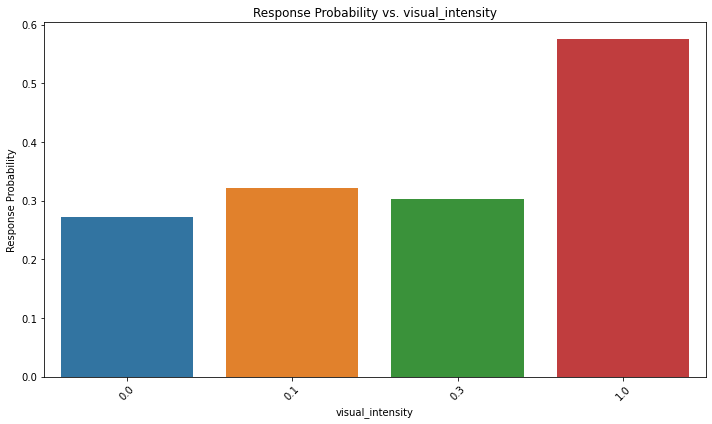

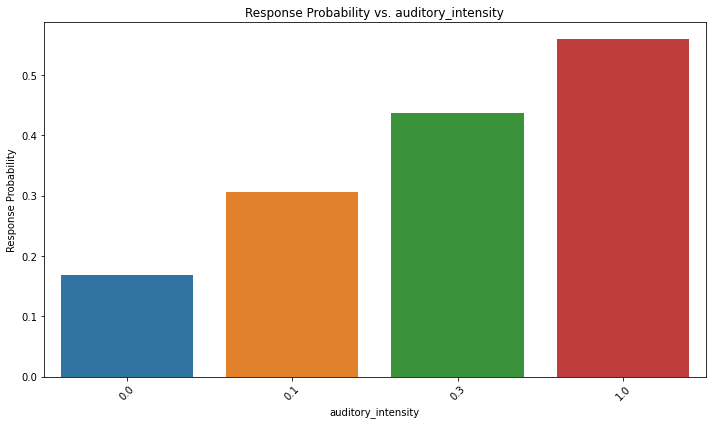

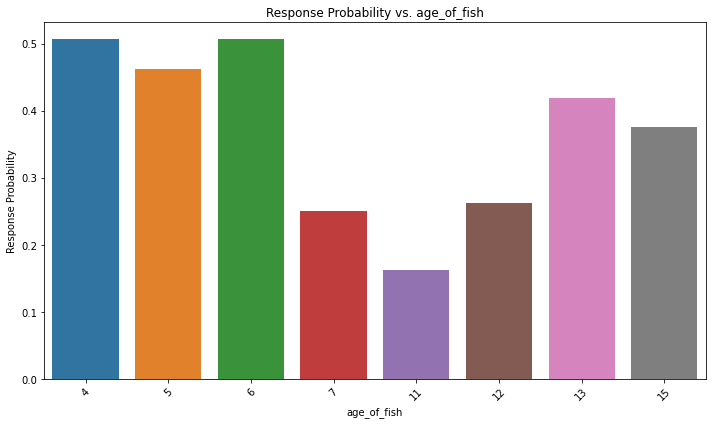

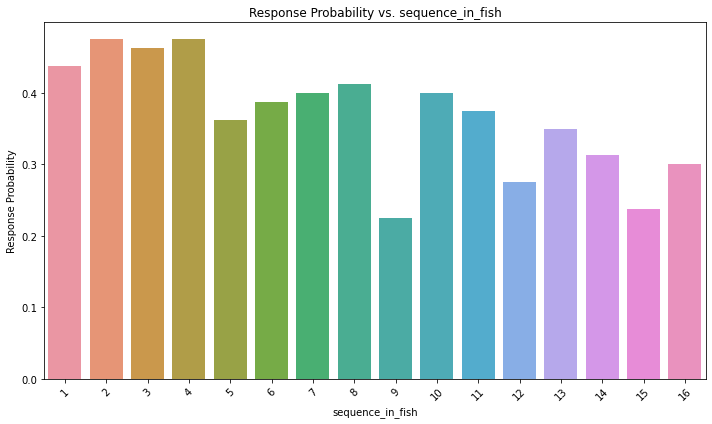

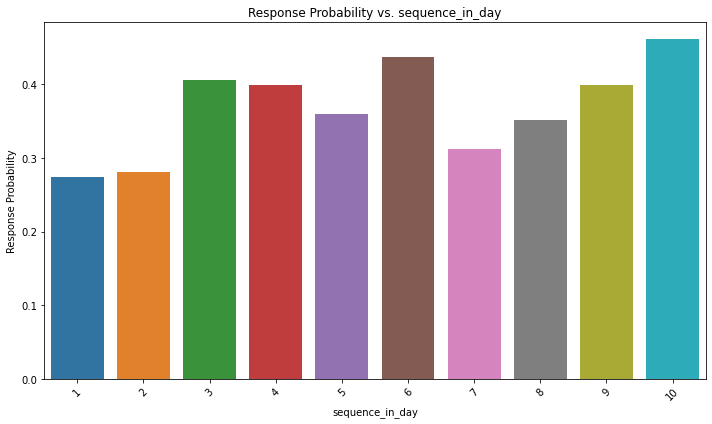

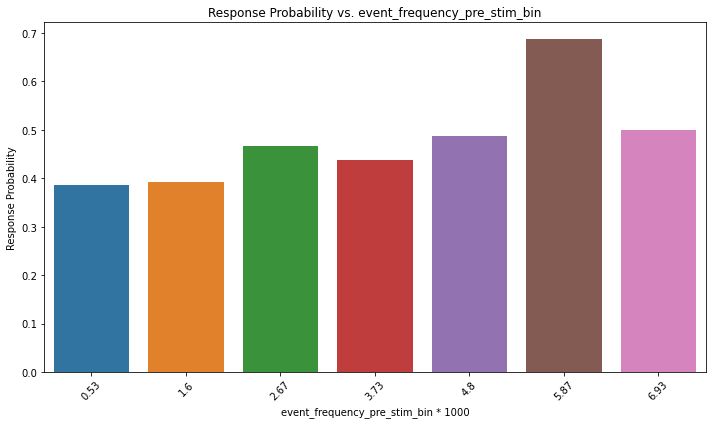

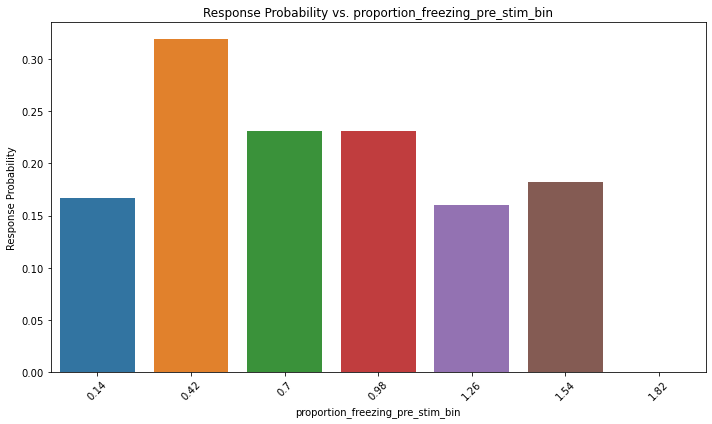

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to calculate and plot response probabilities
def plot_response_prob(df, feature, bins=None, scale=1):
    if bins is not None:
        bin_labels = [str(round(bins[i]*scale + bins[i+1]*scale,2)) for i in range(len(bins)-1)]
        df[feature+'_bin'] = pd.cut(df[feature], bins=bins, labels=bin_labels)
        feature = feature+'_bin'
    
    grouped = df.groupby(feature).mean()['is_escape']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=grouped.index, y=grouped.values)
    plt.ylabel('Response Probability')
    plt.xlabel(feature) if scale == 1 else plt.xlabel(f'{feature} * {scale}')
    plt.title(f'Response Probability vs. {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for discrete and binned continuous variables
plot_response_prob(df, 'visual_intensity')
plot_response_prob(df, 'auditory_intensity')
plot_response_prob(df, 'age_of_fish')
plot_response_prob(df, 'sequence_in_fish')
plot_response_prob(df, 'sequence_in_day')
plot_response_prob(df, 'event_frequency_pre_stim', bins=np.linspace(0, df['event_frequency_pre_stim'].max(), 8), scale=1000)
plot_response_prob(df, 'proportion_freezing_pre_stim', bins=np.linspace(0, df['proportion_freezing_pre_stim'].max(), 8))

C:\Users\PC\anaconda3\envs\imaging\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


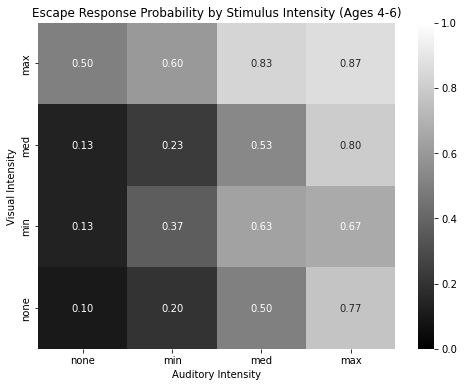

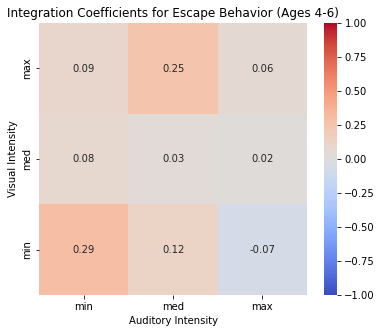

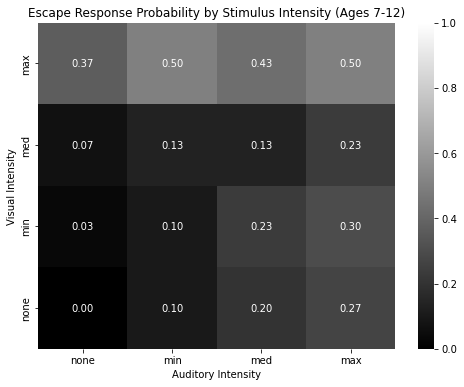

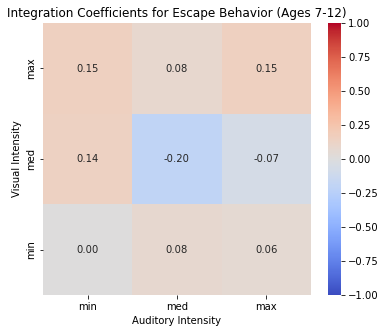

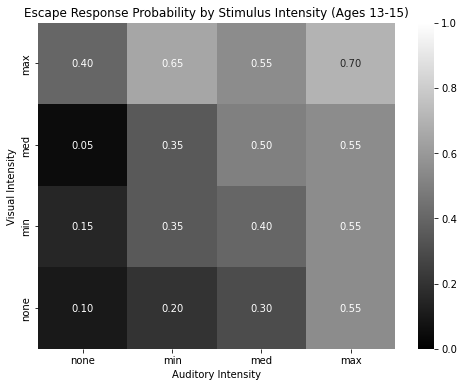

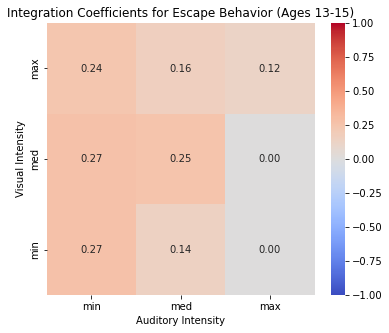

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define age groups
age_groups = {'4-6': range(4, 7), '7-12': range(7, 13), '13-15': range(13, 16)}

# Initialize dictionaries to store the matrices for each age group
escape_probability_matrices = {age_group: np.zeros((4, 4)) for age_group in age_groups}
integration_coefficients_escapes = {age_group: np.zeros((3, 3)) for age_group in age_groups}

stim_start, stim_end = data["stim_window"]

for age_group, ages in age_groups.items():
    # Calculate escape probabilities for each age group and stim type
    for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
        for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
            if visual_intensity == 'none' and auditory_intensity == 'none':
                stim_code = 'ctrl'
            elif visual_intensity == 'none':
                stim_code = f'a{auditory_intensity}'
            elif auditory_intensity == 'none':
                stim_code = f'v{visual_intensity}'
            else:
                stim_code = f'v{visual_intensity}_a{auditory_intensity}'
            
            # Filter trials by age
            age_mask = np.isin(data[stim_code]["age"], list(ages))
            valid_event_times_filtered = np.array(data[stim_code]["valid_event_times"])[age_mask]
            
            # Determine if there is an escape event during the stimulation window
            trials_with_escape = sum(
                any(stim_start < event_time < stim_end for event_time in trial_events)
                for trial_events in valid_event_times_filtered
            )
            total_trials = len(valid_event_times_filtered)
            
            # Calculate the proportion of trials with escape
            escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
            escape_probability_matrices[age_group][visual_idx, auditory_idx] = escape_probability

    # Calculate integration coefficients for each age group
    for v_index in range(1, 4):
        for a_index in range(1, 4):
            observed = escape_probability_matrices[age_group][v_index, a_index]
            v = escape_probability_matrices[age_group][v_index, 0]
            a = escape_probability_matrices[age_group][0, a_index]
            expected = max(v, a)  # Using max(v, a) for superadditivity
            integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
            integration_coefficients_escapes[age_group][v_index-1, a_index-1] = integration_coefficient

# Plot the matrices for each age group
for age_group in age_groups:
    plt.figure(figsize=(8, 6))
    sns.heatmap(escape_probability_matrices[age_group], annot=True, fmt=".2f", cmap='gray',
                xticklabels=['none', 'min', 'med', 'max'],
                yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
    plt.title(f'Escape Response Probability by Stimulus Intensity (Ages {age_group})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(integration_coefficients_escapes[age_group], annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
    plt.title(f'Integration Coefficients for Escape Behavior (Ages {age_group})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()


C:\Users\PC\anaconda3\envs\imaging\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


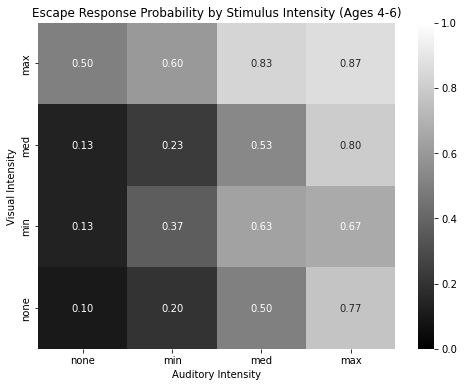

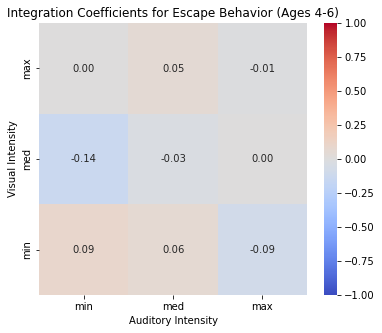

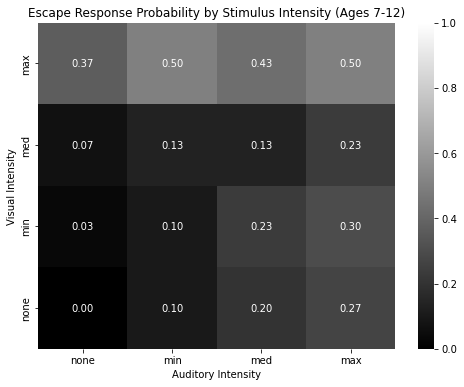

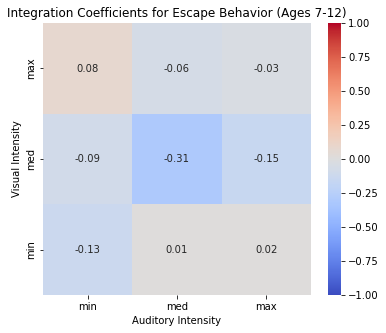

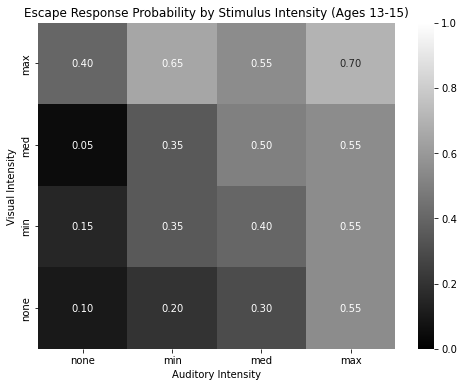

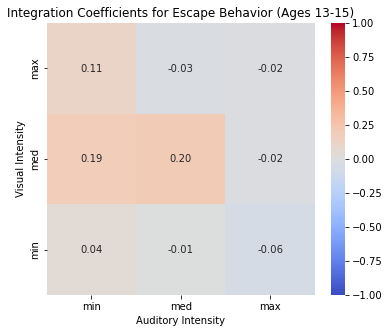

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define age groups
age_groups = {'4-6': range(4, 7), '7-12': range(7, 13), '13-15': range(13, 16)}

# Initialize dictionaries to store the matrices for each age group
escape_probability_matrices = {age_group: np.zeros((4, 4)) for age_group in age_groups}
integration_coefficients_escapes = {age_group: np.zeros((3, 3)) for age_group in age_groups}

stim_start, stim_end = data["stim_window"]

for age_group, ages in age_groups.items():
    # Calculate escape probabilities for each age group and stim type
    for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
        for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
            if visual_intensity == 'none' and auditory_intensity == 'none':
                stim_code = 'ctrl'
            elif visual_intensity == 'none':
                stim_code = f'a{auditory_intensity}'
            elif auditory_intensity == 'none':
                stim_code = f'v{visual_intensity}'
            else:
                stim_code = f'v{visual_intensity}_a{auditory_intensity}'
            
            # Filter trials by age
            age_mask = np.isin(data[stim_code]["age"], list(ages))
            valid_event_times_filtered = np.array(data[stim_code]["valid_event_times"])[age_mask]
            
            # Determine if there is an escape event during the stimulation window
            trials_with_escape = sum(
                any(stim_start < event_time < stim_end for event_time in trial_events)
                for trial_events in valid_event_times_filtered
            )
            total_trials = len(valid_event_times_filtered)
            
            # Calculate the proportion of trials with escape
            escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
            escape_probability_matrices[age_group][visual_idx, auditory_idx] = escape_probability

    # Calculate integration coefficients for each age group
    for v_index in range(1, 4):
        for a_index in range(1, 4):
            observed = escape_probability_matrices[age_group][v_index, a_index]
            v = escape_probability_matrices[age_group][v_index, 0]
            a = escape_probability_matrices[age_group][0, a_index]
            expected = v + a - v*a
            integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
            integration_coefficients_escapes[age_group][v_index-1, a_index-1] = integration_coefficient

# Plot the matrices for each age group
for age_group in age_groups:
    plt.figure(figsize=(8, 6))
    sns.heatmap(escape_probability_matrices[age_group], annot=True, fmt=".2f", cmap='gray',
                xticklabels=['none', 'min', 'med', 'max'],
                yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
    plt.title(f'Escape Response Probability by Stimulus Intensity (Ages {age_group})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(integration_coefficients_escapes[age_group], annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
    plt.title(f'Integration Coefficients for Escape Behavior (Ages {age_group})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()


C:\Users\PC\anaconda3\envs\imaging\lib\site-packages\ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


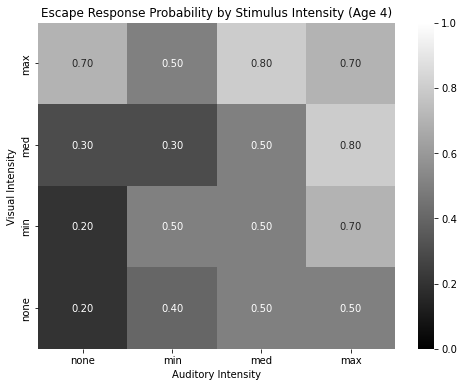

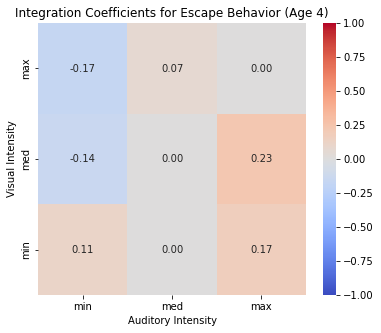

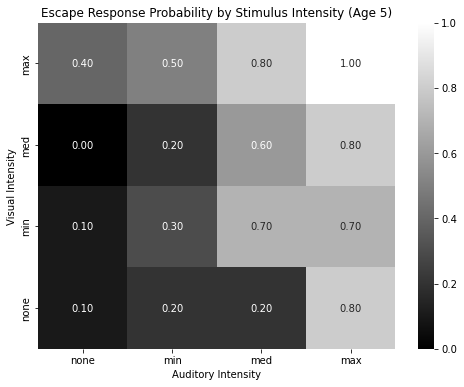

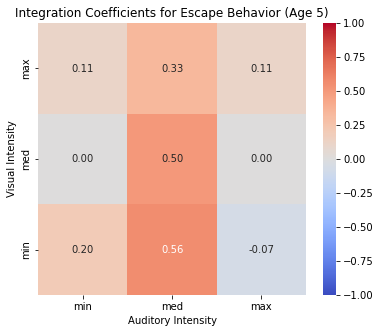

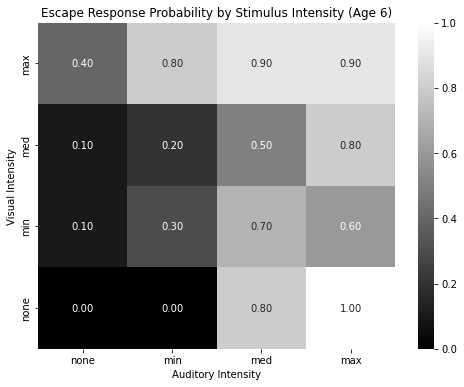

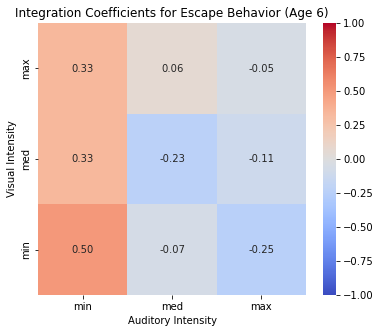

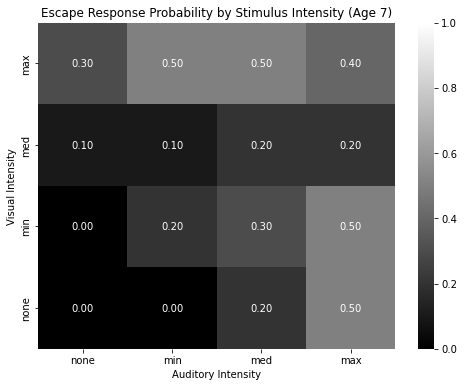

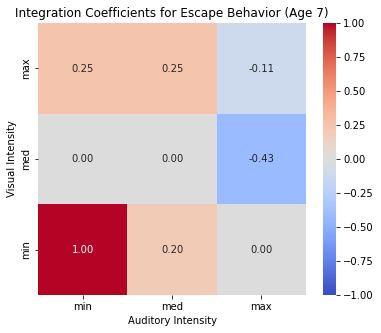

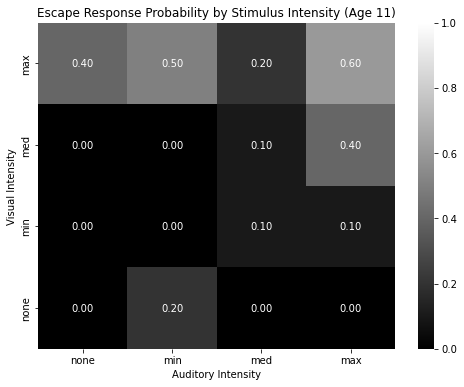

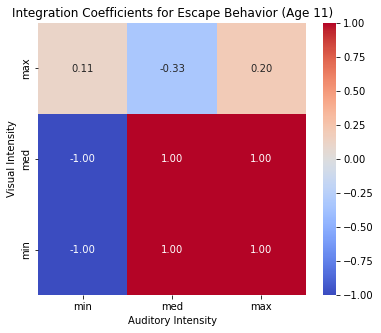

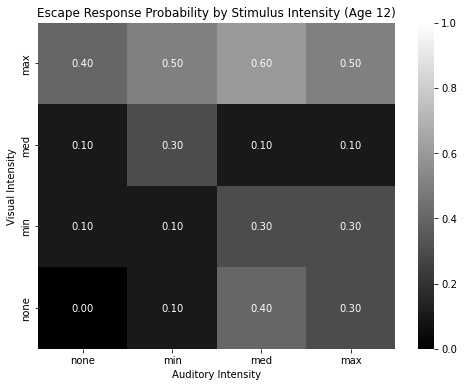

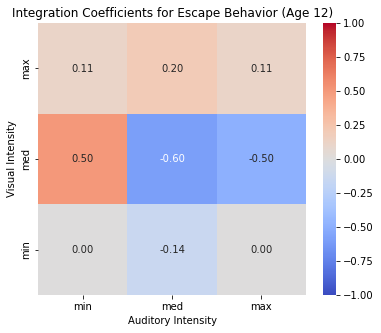

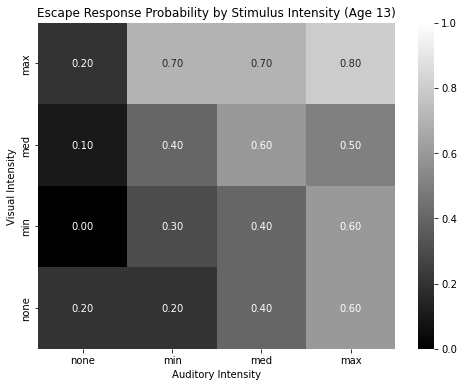

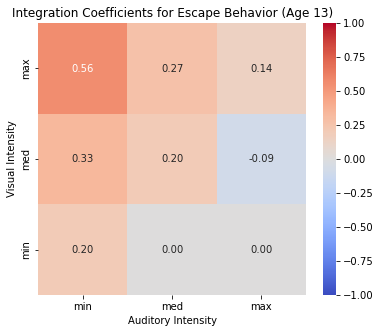

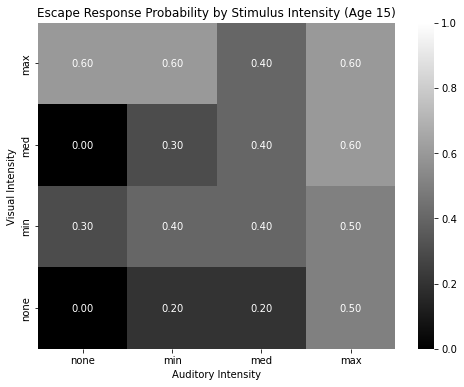

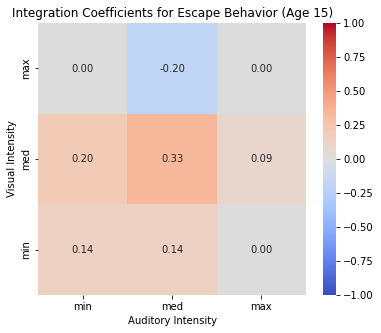

In [7]:
import pandas as pd

# Create an empty DataFrame to store integration values and corresponding attributes
integration_data = pd.DataFrame(columns=['integration', 'visual_intensity', 'auditory_intensity', 'age'])

# Identify all unique ages in the dataset
unique_ages = np.unique(np.concatenate([data[stim_code]["age"] for stim_code in data if stim_code != "stim_time" and stim_code != "stim_window" and stim_code != "colors" and stim_code != "stim_labels"]))

# Initialize dictionaries to store the matrices for each unique age
escape_probability_matrices_age = {age: np.zeros((4, 4)) for age in unique_ages}
integration_coefficients_escapes_age = {age: np.zeros((3, 3)) for age in unique_ages}

for age in unique_ages:
    # Calculate escape probabilities for each stim type at this specific age
    for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
        for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
            if visual_intensity == 'none' and auditory_intensity == 'none':
                stim_code = 'ctrl'
            elif visual_intensity == 'none':
                stim_code = f'a{auditory_intensity}'
            elif auditory_intensity == 'none':
                stim_code = f'v{visual_intensity}'
            else:
                stim_code = f'v{visual_intensity}_a{auditory_intensity}'
            
            # Filter trials by this specific age
            age_mask = data[stim_code]["age"] == age
            valid_event_times_filtered = np.array(data[stim_code]["valid_event_times"])[age_mask]
            
            # Determine if there is an escape event during the stimulation window
            trials_with_escape = sum(
                any(stim_start < event_time < stim_end for event_time in trial_events)
                for trial_events in valid_event_times_filtered
            )
            total_trials = len(valid_event_times_filtered)
            
            # Calculate the proportion of trials with escape
            escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
            escape_probability_matrices_age[age][visual_idx, auditory_idx] = escape_probability

    # Calculate integration coefficients for each specific age
    for v_index in range(1, 4):
        for a_index in range(1, 4):
            observed = escape_probability_matrices_age[age][v_index, a_index]
            v = escape_probability_matrices_age[age][v_index, 0]
            a = escape_probability_matrices_age[age][0, a_index]
            expected = max(v, a)
            integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
            integration_coefficients_escapes_age[age][v_index-1, a_index-1] = integration_coefficient
            
            # Append integration data to the DataFrame
            integration_data = integration_data.append({
                'integration': integration_coefficient,
                'visual_intensity': visual_idx - 1,  # Subtracting 1 to map 1-3 to 0-2 (min-med-max)
                'auditory_intensity': a_index - 1,  # Subtracting 1 to map 1-3 to 0-2 (min-med-max)
                'age': age
            }, ignore_index=True)


# Plot the matrices for each unique age
for age in unique_ages:
    plt.figure(figsize=(8, 6))
    sns.heatmap(escape_probability_matrices_age[age], annot=True, fmt=".2f", cmap='gray',
                xticklabels=['none', 'min', 'med', 'max'],
                yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
    plt.title(f'Escape Response Probability by Stimulus Intensity (Age {age})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(integration_coefficients_escapes_age[age], annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
    plt.title(f'Integration Coefficients for Escape Behavior (Age {age})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()


In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Add a constant term for the intercept
integration_data['intercept'] = 1



# Define the model formula
formula = 'integration ~ visual_intensity + auditory_intensity + age'

# Fit the GLM
model = smf.glm(formula=formula, data=integration_data, family=sm.families.Gaussian()).fit()

# Print the summary to see the results
print(model.summary())

# Define the model formula
formula = 'integration ~ age'

# Fit the GLM
model = smf.glm(formula=formula, data=integration_data, family=sm.families.Gaussian()).fit()

# Print the summary to see the results
print(model.summary())


# Add a constant term for the intercept
integration_data['intensity'] = integration_data['visual_intensity'] + integration_data['auditory_intensity']

# Define the model formula
formula = 'integration ~ intensity'

# Fit the GLM
model = smf.glm(formula=formula, data=integration_data, family=sm.families.Gaussian()).fit()

# Print the summary to see the results
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            integration   No. Observations:                   72
Model:                            GLM   Df Residuals:                       69
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.14435
Method:                          IRLS   Log-Likelihood:                -30.952
Date:                Mon, 18 Mar 2024   Deviance:                       9.9600
Time:                        15:36:40   Pearson chi2:                     9.96
No. Iterations:                     3   Pseudo R-squ. (CS):           0.004002
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0255      0

C:\Users\PC\anaconda3\envs\imaging\lib\site-packages\ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


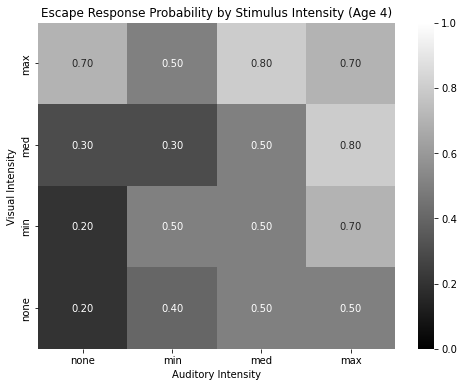

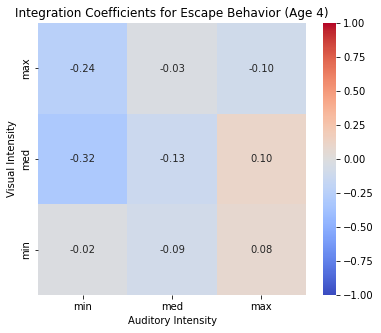

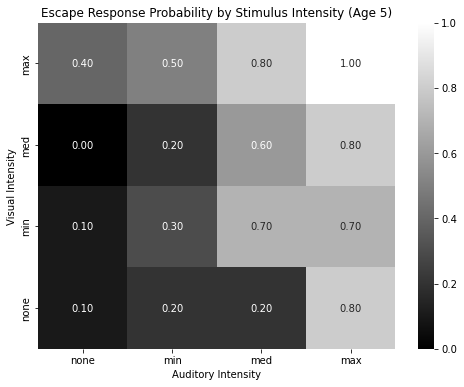

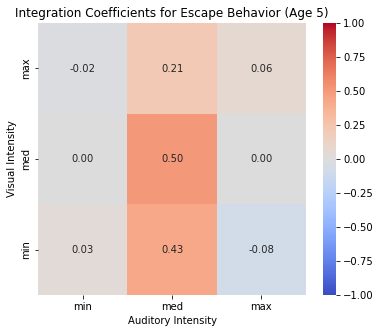

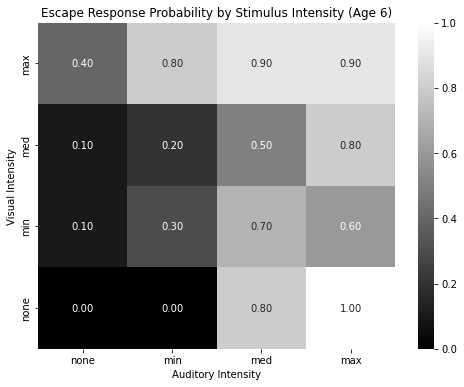

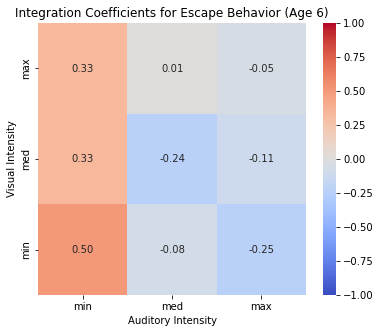

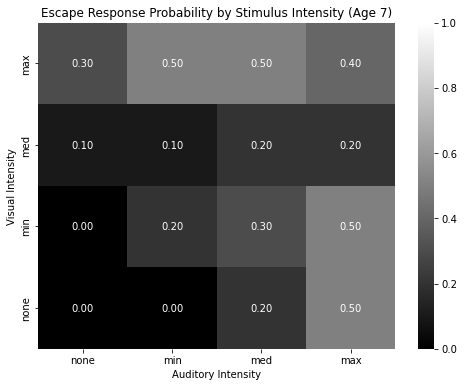

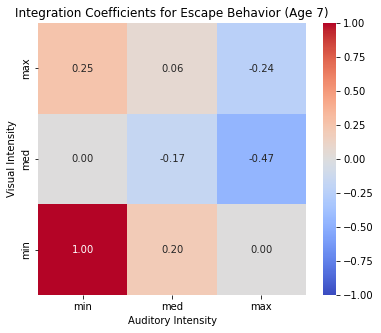

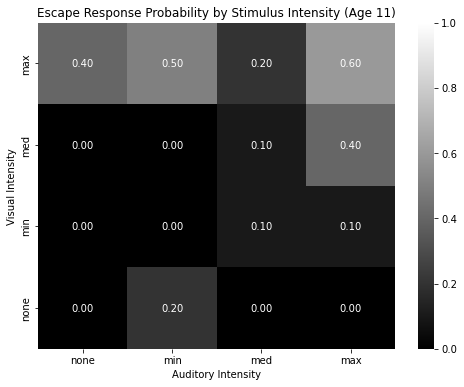

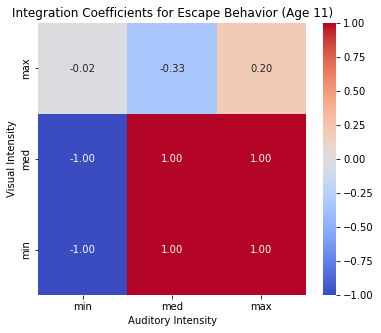

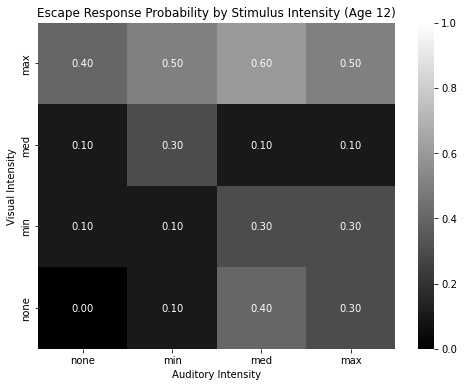

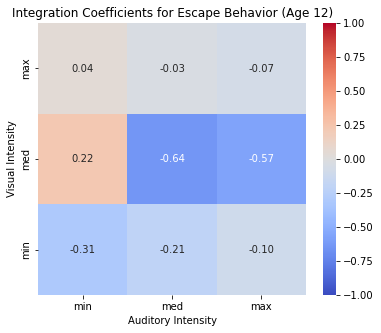

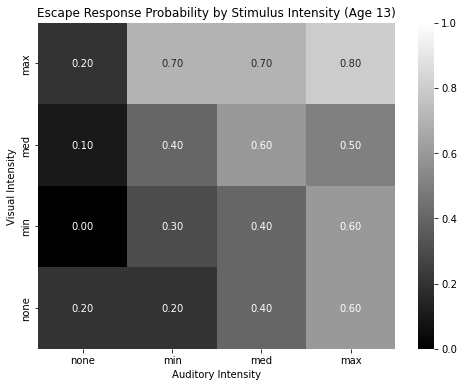

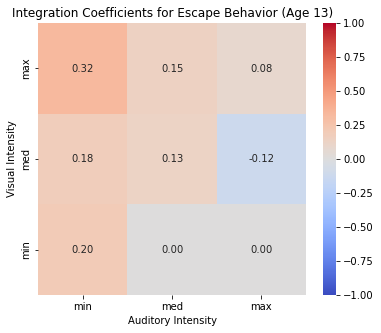

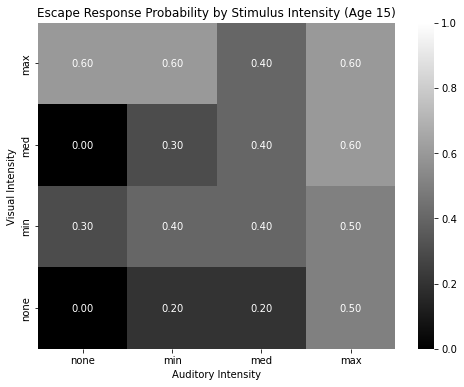

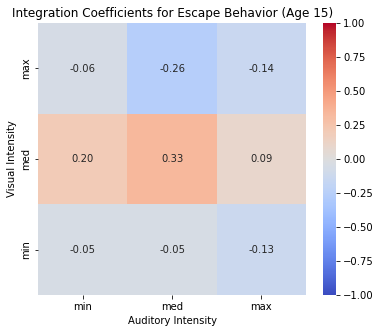

In [9]:
import pandas as pd

# Create an empty DataFrame to store integration values and corresponding attributes
integration_data = pd.DataFrame(columns=['integration', 'visual_intensity', 'auditory_intensity', 'age'])

# Identify all unique ages in the dataset
unique_ages = np.unique(np.concatenate([data[stim_code]["age"] for stim_code in data if stim_code != "stim_time" and stim_code != "stim_window" and stim_code != "colors" and stim_code != "stim_labels"]))

# Initialize dictionaries to store the matrices for each unique age
escape_probability_matrices_age = {age: np.zeros((4, 4)) for age in unique_ages}
integration_coefficients_escapes_age = {age: np.zeros((3, 3)) for age in unique_ages}

for age in unique_ages:
    # Calculate escape probabilities for each stim type at this specific age
    for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
        for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
            if visual_intensity == 'none' and auditory_intensity == 'none':
                stim_code = 'ctrl'
            elif visual_intensity == 'none':
                stim_code = f'a{auditory_intensity}'
            elif auditory_intensity == 'none':
                stim_code = f'v{visual_intensity}'
            else:
                stim_code = f'v{visual_intensity}_a{auditory_intensity}'
            
            # Filter trials by this specific age
            age_mask = data[stim_code]["age"] == age
            valid_event_times_filtered = np.array(data[stim_code]["valid_event_times"])[age_mask]
            
            # Determine if there is an escape event during the stimulation window
            trials_with_escape = sum(
                any(stim_start < event_time < stim_end for event_time in trial_events)
                for trial_events in valid_event_times_filtered
            )
            total_trials = len(valid_event_times_filtered)
            
            # Calculate the proportion of trials with escape
            escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
            escape_probability_matrices_age[age][visual_idx, auditory_idx] = escape_probability

    # Calculate integration coefficients for each specific age
    for v_index in range(1, 4):
        for a_index in range(1, 4):
            observed = escape_probability_matrices_age[age][v_index, a_index]
            v = escape_probability_matrices_age[age][v_index, 0]
            a = escape_probability_matrices_age[age][0, a_index]
            expected = v + a - v*a
            integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
            integration_coefficients_escapes_age[age][v_index-1, a_index-1] = integration_coefficient
            
            # Append integration data to the DataFrame
            integration_data = integration_data.append({
                'integration': integration_coefficient,
                'visual_intensity': visual_idx - 1,  # Subtracting 1 to map 1-3 to 0-2 (min-med-max)
                'auditory_intensity': a_index - 1,  # Subtracting 1 to map 1-3 to 0-2 (min-med-max)
                'age': age
            }, ignore_index=True)


# Plot the matrices for each unique age
for age in unique_ages:
    plt.figure(figsize=(8, 6))
    sns.heatmap(escape_probability_matrices_age[age], annot=True, fmt=".2f", cmap='gray',
                xticklabels=['none', 'min', 'med', 'max'],
                yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
    plt.title(f'Escape Response Probability by Stimulus Intensity (Age {age})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(integration_coefficients_escapes_age[age], annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
    plt.title(f'Integration Coefficients for Escape Behavior (Age {age})')
    plt.xlabel('Auditory Intensity')
    plt.ylabel('Visual Intensity')
    plt.gca().invert_yaxis()
    plt.show()


In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Add a constant term for the intercept
integration_data['intercept'] = 1



# Define the model formula
formula = 'integration ~ visual_intensity + auditory_intensity + age'

# Fit the GLM
model = smf.glm(formula=formula, data=integration_data, family=sm.families.Gaussian()).fit()

# Print the summary to see the results
print(model.summary())

# Define the model formula
formula = 'integration ~ age'

# Fit the GLM
model = smf.glm(formula=formula, data=integration_data, family=sm.families.Gaussian()).fit()

# Print the summary to see the results
print(model.summary())


# Add a constant term for the intercept
integration_data['intensity'] = integration_data['visual_intensity'] + integration_data['auditory_intensity']

# Define the model formula
formula = 'integration ~ intensity'

# Fit the GLM
model = smf.glm(formula=formula, data=integration_data, family=sm.families.Gaussian()).fit()

# Print the summary to see the results
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            integration   No. Observations:                   72
Model:                            GLM   Df Residuals:                       69
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.14848
Method:                          IRLS   Log-Likelihood:                -31.970
Date:                Mon, 18 Mar 2024   Deviance:                       10.245
Time:                        15:36:57   Pearson chi2:                     10.2
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001477
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0116      0

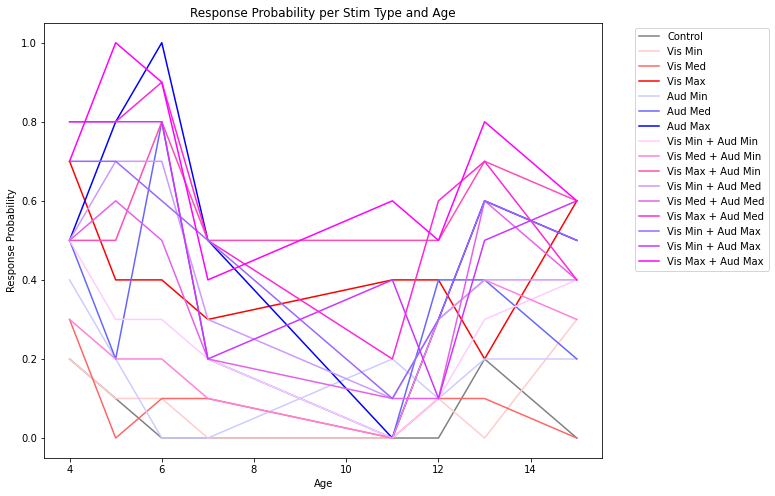

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming organized_data is your main data structure

# Step 1: Calculate response probability per stim type and age group
response_probabilities = {}  # {stim_type: {age: probability, ...}, ...}

stim_types = data["colors"].keys()

for stim_type in stim_types:
    # Extract age and is_escape data
    ages = data[stim_type]["age"]
    escapes = data[stim_type]["is_escape"]
    
    # Group by age and calculate response probability
    age_groups = np.unique(ages)
    stim_response_probabilities = {}
    
    for age in age_groups:
        is_escape_at_age = escapes[ages == age]
        probability = np.mean(is_escape_at_age)
        stim_response_probabilities[age] = probability
    
    response_probabilities[stim_type] = stim_response_probabilities

# Step 2: Prepare the data for plotting - done during plotting to keep the structure simple

# Step 3: Plot
plt.figure(figsize=(10, 8))

for stim_type, age_probs in response_probabilities.items():
    ages = list(age_probs.keys())
    probabilities = list(age_probs.values())
    plt.plot(ages, probabilities, label=data["stim_labels"][stim_type], color=data["colors"][stim_type])

plt.xlabel('Age')
plt.ylabel('Response Probability')
plt.title('Response Probability per Stim Type and Age')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
